# Wildfire Visualization and OpenEO


This notebook demonstrates how to visualize wildfire occurrences using Sentinel-2 imagery. The visualization applies cartographic-style rendering that the author can switch between different purposes.

The available styles include:
1. A continuous heatmap-like visualization where fire intensity (from weak to strong) is encoded using SWIR-based thresholds and blended into a base map that preserves soil, built-up areas, vegetation, and water bodies.
2. Binary fire detection styles using read or yellow coloring to indicate the presence or absence of active fires.
3. Context-preserving binary styles that highlight fire pixels while maintaining the underlying land-cover information for situational awareness.

The visualization also includes optional cloud avoidance logic to reduce false detections, and supports burn-scar highlighting using the Normalized Burn Ration (NBR) to visualize post-fire impacts. Other enhancements, such as contrast and saturation, are applied to beautify the visualization. 

In [48]:
import openeo
import matplotlib.pyplot as plt
from PIL import Image
from openeo.processes import array_create, if_, and_, array_element
from wildfire_viz_helper import stretch, satEnh, layer_blend, isCloud, not_, or_
from wildfire_viz_color_arrays import naturalColorsCC_arr, naturalColors_arr, urban_arr

# Connect to OpenEO Backend
Connect to the OpenEO backend and authenticate using OpenID Connect.

In [49]:
connection = openeo.connect(
    url="https://api.explorer.eopf.copernicus.eu/openeo"
    # url="http://127.0.0.1:8081/"
).authenticate_oidc_authorization_code()

# Define Area of Interest
Define the spatial extent for our analysis. This example uses coordinates for Battleship Mountain, B.C., Canada

In [ ]:
# Lukovo area, Croatia
spatial_extent = {
    "west": 14.882795218158861,
    "east": 14.913869863464043,
    "south": 44.84231291017926,
    "north": 44.859776923695904
}

# Load Sentinel-2 Data
Load Sentinel-2 L2A data. We need multiple bands to visualize the underlying land-cover information, water, and wildfire.

- **B02**: Blue, 492.4 nm
- **B03**: Green, 559.8 nm
- **B04**: Red, 664.6 nm
- **B08**: NIR, 832.8 nm
- **B8A**: Narrow NIR, 864.7 nm
- **B11**: SWIR, 1613.7 nm
- **B12**: SWIR, 2202.4 nm


In [51]:
# s2cube = connection.load_collection(
#     "sentinel-2-l2a",
#     spatial_extent=spatial_extent,
#     temporal_extent=["2025-07-03", "2025-07-10"],
#     bands=["reflectance|b02", "reflectance|b03", "reflectance|b04", "reflectance|b08", "reflectance|b11", "reflectance|b12"]
# )
# s2cube = s2cube.reduce_dimension(dimension="t", reducer="first")  # single timestamp for PNG


In [52]:
s2cube = connection.datacube_from_process(
    "load_zarr",
    url="s3://esa-zarr-sentinel-explorer-fra/tests-output/sentinel-2-l2a/S2B_MSIL2A_20250524T100029_N0511_R122_T33TVK_20250524T125315.zarr",
    spatial_extent={
        "east" : spatial_extent["east"],
        "north" : spatial_extent["north"],
        "west" : spatial_extent["west"],
        "south" : spatial_extent["south"]
    },
    options={
        "variables": [
            "/measurements/reflectance/r10m:b02",
            "/measurements/reflectance/r10m:b03",
            "/measurements/reflectance/r10m:b04",
            "/measurements/reflectance/r10m:b08",
            "/measurements/reflectance/r20m:b11",
            "/measurements/reflectance/r20m:b12"
        ],
        "width" : 1024,
        "height" : 1024
    }
)

### Wildfire Visualization Styles

The `wildfire_viz_style` helper lets you choose among four preset visual styles for highlighting active fire pixels. You need to enable hotspot rendering to use any of these styles (`hotspot = 1`):

- **`style = 1` – Continuous heatmap**: Shows hotspots with a smooth color ramp, where **strong fire** appears in bright yellow and **weaker fire** in darker reds.
- **`style = 2` – Binary red mask**: Highlights pixels classified as fire in **bright red**, with non‑fire areas shown in a neutral background.
- **`style = 3` – Binary yellow mask**: Similar to style 2, but fire pixels are shown in **bright yellow**, useful on darker backgrounds or when combining with other layers.
- **`style = 4` – Contextual fire map**: Emphasizes fire pixels with a bright color while also rendering other land‑cover types (e.g. urban areas, vegetation) with more subdued tones, giving context to where the fire occurs.

You can also visualize burn scars by disabling hotspot rendering (`hotspot = 0`) and enabling burn scar rendering (`showBurnScars = 1`). Style selection only applies to hotspot visualization and is not available when `showBurnScars` is used.

The wildfire layer is drawn on top of a base map that shows land cover such as soil, built-up areas, vegetation, and water. In this notebook, the default base map is a blend of urban composite, true color, and color-corrected true color. To use a different base map, replace `urban`, `naturalColors`, or `naturalColorsCC` in the blend with any other color composite defined in `notebooks/sentinel/sentinel-2/fire_and_disaster_monitoring/wildfire_viz_color_arrays.py`. You can change the look of the base map without changing the wildfire visualization logic.

In [ ]:
# If user wants to visualize the hotspots, they can set the hotspot variable to 1
hotspot = 1

# If user wants to visualize the hotspots in a continuous heatmap-style, they can set the style variable to 1
style = 2

# If user wants to visualize the burn scars, they can set the showBurnScars variable to 1, and hotspot to 0
showBurnScars = 0

# Define the file name for downloading the image
if hotspot:
    if style:
        file_name = f"wildfire_hotspot_style{style}.png"
if showBurnScars:
    file_name = f"wildfire_burntscar.png"

# Threshold for hotspot intensity
hsThreshold = [2.0, 1.5, 1.25, 1.0]
hsSensitivity = 1.0
boost = 1

# Threshold for cloud probability
cloudAvoidance = 1
cloudAvoidanceThreshold = 245
avoidanceHelper = 0.8

# Image brightness, saturation, and contrast
offset = -0.000
saturation = 1.10
brightness = 1.00
sMin = 0.01
sMax = 0.99

# Threshold for burn scars
burnScarThreshold = -0.25
burnScarStrength = 0.3

# Threshold for water
waterHighlight = 0
waterBoost = 2.0
waterHelper = 0.2

# Index thresholds
NDVI_threshold = -0.15
NDWI_threshold = 0.15


In [54]:
def wildfire_viz_style(base_arr, b02, b03, b04, b11, b12, b08=None):
    base_r = array_element(base_arr, 0)
    base_g = array_element(base_arr, 1)
    base_b = array_element(base_arr, 2)
    
    if hotspot:
        clp = isCloud(b03, b04)

        cloud_mask = and_(clp < cloudAvoidanceThreshold, b02 < avoidanceHelper)

        swir_sum = b12 + b11

        if style == 1:
            mask_0 = and_(
                cloud_mask, 
                (swir_sum > (hsThreshold[0] / hsSensitivity))
            )

            mask_1 = and_(
                cloud_mask,
                and_(
                    swir_sum > (hsThreshold[1] / hsSensitivity),
                    not_(mask_0)
                )
            )

            mask_2 = and_(
                cloud_mask,
                and_(
                    swir_sum > (hsThreshold[2] / hsSensitivity),
                    not_(or_(mask_0, mask_1))
                )
            )

            mask_3 = and_(
                cloud_mask,
                and_(
                    swir_sum > (hsThreshold[3] / hsSensitivity),
                    not_(or_(mask_0, or_(mask_1, mask_2)))
                )
            )

            # Any hotspot present
            mask_any = or_(mask_0, or_(mask_1, or_(mask_2, mask_3)))

            # Any hotspot must be colored red
            r = base_r + (boost * 0.5 * b12 * mask_any)

            # Weights green channel by hotspot classes
            g = base_g + (
                boost * b11 * (
                    0.5 * mask_0 + 
                    0.2 * mask_1 + 
                    0.1 * mask_2 + 
                    0.0 * mask_3
                )
            )

            # Blue channel remains unchanged
            b = base_b

            return array_create([r, g, b])

        # Different styles for binary colors
        fire_mask = and_(cloud_mask, (swir_sum > (hsThreshold[3] / hsSensitivity)))
        if style == 2:
            return array_create([
                if_(fire_mask, 1, base_r),
                if_(fire_mask, 0, base_g),
                if_(fire_mask, 0, base_b)
            ])
        
        if style == 3:
            return array_create([
                if_(fire_mask, 1, base_r),
                if_(fire_mask, 1, base_g),
                if_(fire_mask, 0, base_b)
            ])

        if style == 4:
            return array_create([
                if_(fire_mask, base_r + 0.2, base_r),
                if_(fire_mask, base_g - 0.2, base_g),
                if_(fire_mask, base_b - 0.2, base_b)
            ])
            
    if showBurnScars:
        if b08 is None:
            raise ValueError("B08 is required when showBurnScars is True")

        NBR = (b08 - b12) / (b08 + b12)
        NBR_mask = NBR < burnScarThreshold
        
        r = if_(
            NBR_mask, 
            base_r + burnScarStrength,
            base_r
        )

        g = if_(
            NBR_mask,
            base_g + burnScarStrength,
            base_g
        )

        b = base_b

        return array_create([r, g, b])
    
    return base_arr

In [55]:
def wildfire_visualization(data):
    # Extract bands, remove band 1 and band 8a
    B02, B03, B04, B08, B11, B12 = (
        data[0],
        data[1],
        data[2],
        data[3],
        data[4],
        data[5],
    )

    # Calculate indexes for vegetation, water, and burnt areas
    NDWI = (B03 - B08) / (B03 + B08)
    NDVI = (B08 - B04) / (B08 + B04)

    # True colors with color correction
    naturalColorsCC = naturalColorsCC_arr(brightness, B04, B03, B02, offset)

    # True colors
    naturalColors = naturalColors_arr(brightness, B04, B03, B02, offset)

    # SWIR composite for urban areas
    urban = urban_arr(brightness, B12, B11, B04, offset)

    # Create wildfire visualization base map as an RGB combination from URBAN, naturalColors, naturalColorsCC
    # User can choose to use other color arrays already defined above to create the visualization base map
    baseViz = layer_blend(urban, naturalColors, naturalColorsCC, 10, 40, 50)

    # Coloring the water
    baseViz_red = array_element(baseViz, 0)

    water_detection = and_(and_(NDVI < NDVI_threshold, NDWI > NDWI_threshold), B04 < waterHelper)

    baseViz_green = if_(
        waterHighlight,
        if_(
            water_detection,
            array_element(baseViz, 1) * 1.2 * waterBoost + 0.1,
            array_element(baseViz, 1)
        ),
        array_element(baseViz, 1)
    )

    baseViz_blue = if_(
        waterHighlight,
        if_(
            water_detection,
            array_element(baseViz, 2) * 1.5 * waterBoost + 0.2,
            array_element(baseViz, 2)
        ),
        array_element(baseViz, 2)
    )

    baseViz = array_create([baseViz_red, baseViz_green, baseViz_blue])

    # Enhance saturation and contrast
    baseViz = satEnh(baseViz, saturation)
    baseViz = stretch(baseViz, sMin, sMax)

    # Pick viz style
    baseViz = wildfire_viz_style(baseViz, B02, B03, B04, B11, B12)

    return baseViz

## Save and Download the Image

Generate the final wildfire image and download it as a PNG file.

In [56]:
wildfire_viz_image = s2cube.apply_dimension(dimension="bands", process=wildfire_visualization)

wildfire_viz_image = wildfire_viz_image.linear_scale_range(input_min=0, input_max=1, output_min=0, output_max=255)

wildfire_viz_image = wildfire_viz_image.save_result("PNG")

In [ ]:
wildfire_viz_image.download(file_name)

Preflight process graph validation failed: [400] InvalidRequest: 1 validation error:
  {'type': 'missing', 'loc': ('body', 'id'), 'msg': 'Field required', 'input': {'process_graph': {'loadzarr1': {'process_id': 'load_zarr', 'arguments': {'options': {'variables': ['/measurements/reflectance/r10m:b02', '/measurements/reflectance/r10m:b03', '/measurements/reflectance/r10m:b04', '/measurements/reflectance/r10m:b08', '/measurements/reflectance/r20m:b11', '/measurements/reflectance/r20m:b12'], 'width': 1024, 'height': 1024}, 'spatial_extent': {'east': 14.913869863464043, 'north': 44.859776923695904, 'west': 14.882795218158861, 'south': 44.84231291017926}, 'url': 's3://esa-zarr-sentinel-explorer-fra/tests-output/sentinel-2-l2a/S2B_MSIL2A_20250524T100029_N0511_R122_T33TVK_20250524T125315.zarr'}}, 'applydimension1': {'process_id': 'apply_dimension', 'arguments': {'data': {'from_node': 'loadzarr1'}, 'dimension': 'bands', 'process': {'process_graph': {'arrayelement1': {'process_id': 'array_elemen

## Visualize the Result

Display the generated wildfire map of different styles.
1. A continuous heatmap-like visualization where fire intensity (from weak to strong) is encoded using SWIR-based thresholds and blended into a base map that preserves soil, built-up areas, vegetation, and water bodies.
2. Binary fire detection styles using read or yellow coloring to indicate the presence or absence of active fires.

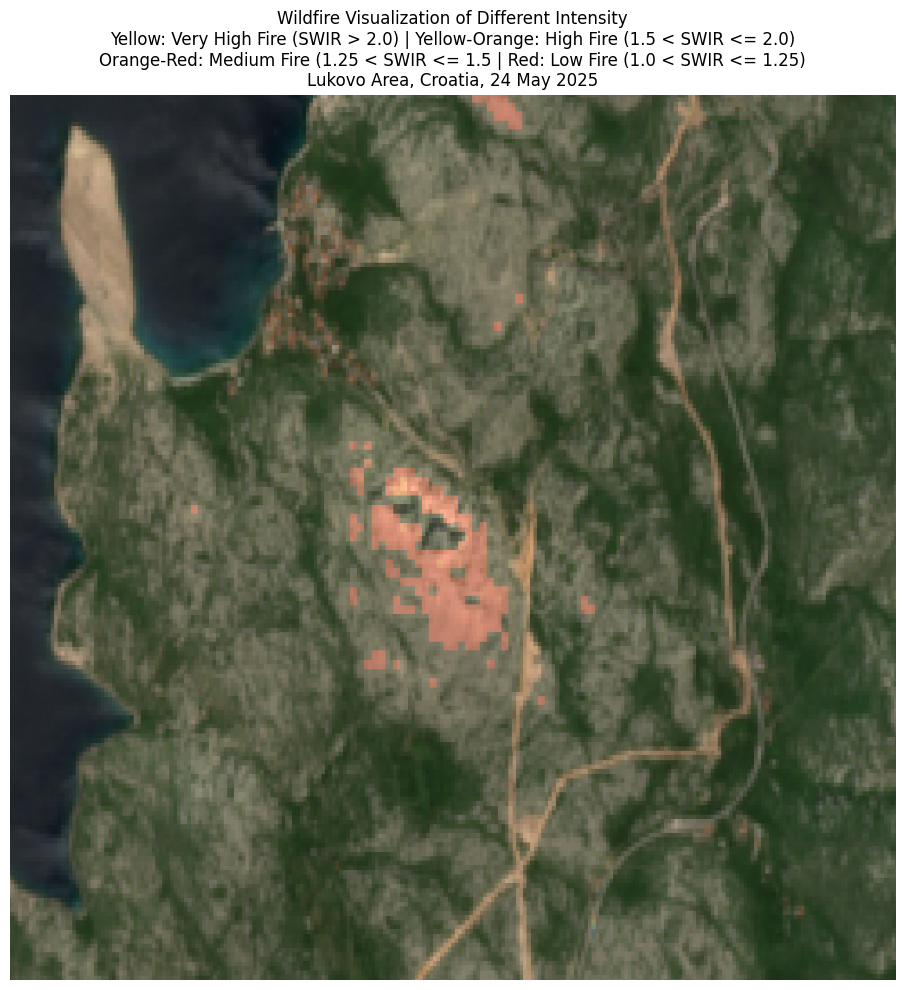

In [47]:
# Load and display the image
img = Image.open("wildfire_hotspot_style1.png")

fig, ax = plt.subplots(figsize=(14, 10), dpi=100)
ax.imshow(img)
ax.set_title(
    "Wildfire Visualization of Different Intensity\n"
    "Yellow: Very High Fire (SWIR > 2.0) | Yellow-Orange: High Fire (1.5 < SWIR <= 2.0)\n"
    "Orange-Red: Medium Fire (1.25 < SWIR <= 1.5 | Red: Low Fire (1.0 < SWIR <= 1.25)\n"
    "Lukovo Area, Croatia, 24 May 2025",
    fontsize=12,
)
ax.axis("off")
plt.tight_layout()
plt.show()

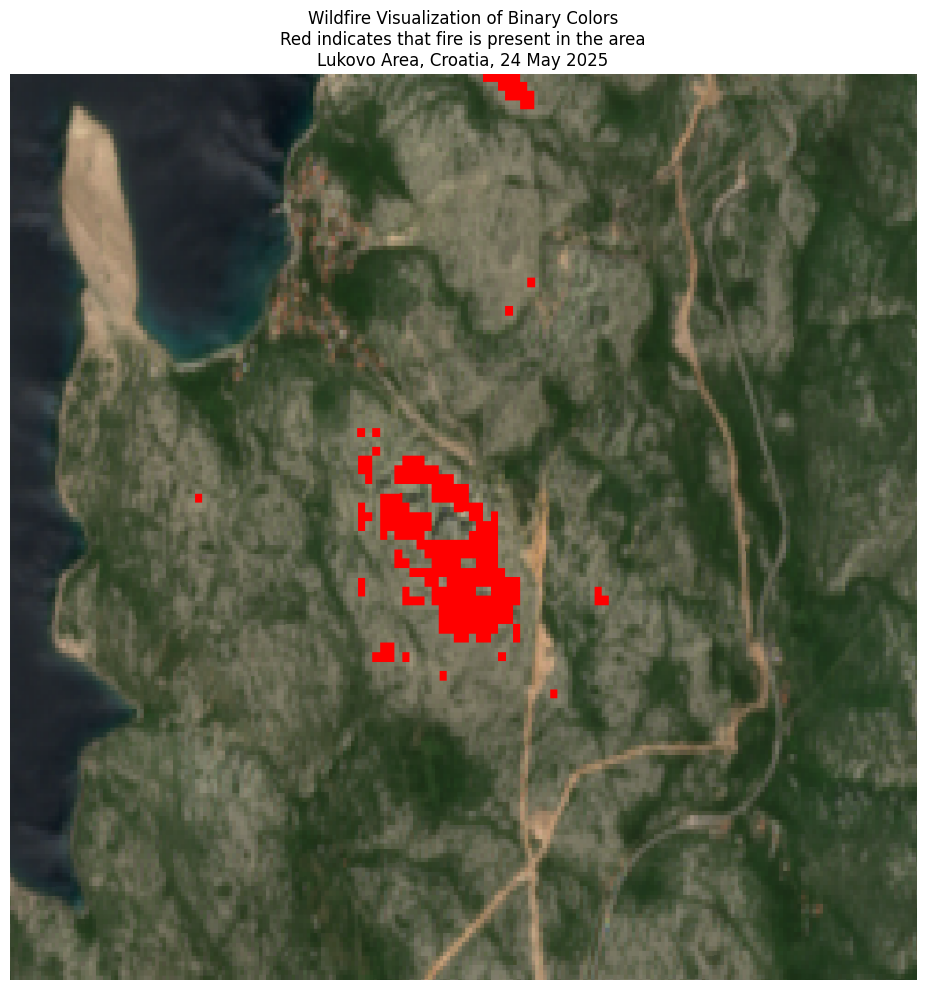

In [59]:
# Load and display the image
img = Image.open("wildfire_hotspot_style2.png")

fig, ax = plt.subplots(figsize=(14, 10), dpi=100)
ax.imshow(img)
ax.set_title(
    "Wildfire Visualization of Binary Colors\n"
    "Red indicates that fire is present in the area\n"
    "Lukovo Area, Croatia, 24 May 2025",
    fontsize=12,
)
ax.axis("off")
plt.tight_layout()
plt.show()

### Citation:

If using this algorithm, please cite:

Markuse, P, 2022. Wildfire Visualization.

### References:

- Markuse, P. (2022, September 21). QuickFire 1.0 – Visualizing Fires in the Sentinel Hub EO Browser. Pierre Markuse. https://web.archive.org/web/20230709082534/https://pierre-markuse.net/2022/09/21/quickfire-1-0-visualizing-fires-in-the-sentinel-hub-eo-browser/

- Markuse, P. (2017). Visualizing (Wild)Fires in Sentinel-2 imagery through EO Browser. Pierre Markuse. https://web.archive.org/web/20230206114533/https://pierre-markuse.net/2017/08/07/visualizing-wildfires-sentinel-2-imagery-eo-browser/

- P. Markuse, QuickFire V1.0.0 – markuse_fire custom script, Sentinel Hub Custom Scripts, GitHub, Sep 2022. https://github.com/sentinel-hub/custom-scripts/blob/main/sentinel-2/markuse_fire/script.js

## Attribution

This openEO User-Defined Process is a conversion of the original Sentinel Hub evalscript:

**Original Script:** [Wildfire Visualization](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/markuse_fire/)

**Author:** Pierre Markuse

**Source Repository:** [Sentinel Hub Custom Scripts](https://github.com/sentinel-hub/custom-scripts)

This conversion maintains the scientific methodology and visualization approach of the original evalscript while adapting it to the openEO process graph framework for interoperability across openEO-compliant backends.